# Predicting Car Prices with Nearest Neighbors

In this short notebook, we are going to describe how to use the **K-Nearest Neighbors** algorithm for regression on car prices.

Say we have a database of cars that have been sold and various attributes of these cars. If we get a new car in stock and want to list it, how could we determine the price?  In this notebook we'll look for the k-nearest cars, for some integer k, according to some similarity metric. Then we'll average what those k cars sold for and that we'll serve as our prediction. This we'll require a lot of data cleaning to get the data in a form so the similarity metric can be computed. We can fine-tune this model by adjusting k, the similarity metric, how we normalize our data, and what features we choose to include in our model.

<h2>Table of Contents</h2>
<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ul>
        <li>Reading, Cleaning, and Preparing the Data</li>
        <li>The K-Nearest Neighbors Regressor</li>
        <ul><li>Additive Smoothing</li></ul>
        <li>Building The Model</li>
        <li>Prediction and Evaluation</li>
        <ul><li>Binary Classification Evaluation Metrics</li><ul>
    </ul>

</div>

<hr>

## Reading and Cleaning Data

The data set we will be working with contains information on various cars. For each car we have information about the technical aspects of the vehicle such as the motor's displacement, the weight of the car, the miles per gallon, how fast the car accelerates, and more. You can read more about the data set [here](https://archive.ics.uci.edu/ml/datasets/automobile) from the very useful UCI machine learning repository. You can download it directly from [here](https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data).

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

cars=pd.read_csv('imports-85.data',header=None)

In [2]:
names=open('imports-85.names')
col_names=[]
pattern=r'\d\. (.*):'
for line in names:
    col=re.findall(pattern,line)
    if len(col)==1:
        col_names.append(col[0])
    

In [3]:
col_names

['Title',
 'Source Information',
 'Past Usage',
 'Relevant Information',
 'Number of Instances',
 'Number of Attributes',
 'Attribute Information',
 'symboling',
 'normalized-losses',
 'make',
 'fuel-type',
 'aspiration',
 'num-of-doors',
 'body-style',
 'drive-wheels',
 'engine-location',
 'wheel-base',
 'length',
 'width',
 'height',
 'curb-weight',
 'engine-type',
 'num-of-cylinders',
 'engine-size',
 'fuel-system',
 'bore',
 'stroke',
 'compression-ratio',
 'horsepower',
 'peak-rpm',
 'city-mpg',
 'highway-mpg',
 'price',
 'Missing Attribute Values']

Looking at the column info in the `.names` file we can safely ignore the first 7 names and the last name which give information about the dataset as a whole rather than any feature of the cars themselves.

In [4]:
col_names=col_names[7:-1]

In [5]:
# Take a look at the data
cars.columns=col_names
cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


The columns have the following info given

1. symboling:                -3, -2, -1, 0, 1, 2, 3.
2. normalized-losses:        continuous from 65 to 256.
3. make:                     alfa-romero, audi, bmw, chevrolet, dodge, honda,
                               isuzu, jaguar, mazda, mercedes-benz, mercury,
                               mitsubishi, nissan, peugot, plymouth, porsche,
                               renault, saab, subaru, toyota, volkswagen, volvo
4. fuel-type:                diesel, gas.
5. aspiration:               std, turbo.
6. num-of-doors:             four, two.
7. body-style:               hardtop, wagon, sedan, hatchback, convertible.
8. drive-wheels:             4wd, fwd, rwd.
9. engine-location:          front, rear.
10. wheel-base:               continuous from 86.6 120.9.
11. length:                   continuous from 141.1 to 208.1.
12. width:                    continuous from 60.3 to 72.3.
13. height:                   continuous from 47.8 to 59.8.
14. curb-weight:              continuous from 1488 to 4066.
15. engine-type:              dohc, dohcv, l, ohc, ohcf, ohcv, rotor.
16. num-of-cylinders:         eight, five, four, six, three, twelve, two.
17. engine-size:              continuous from 61 to 326.
18. fuel-system:              1bbl, 2bbl, 4bbl, idi, mfi, mpfi, spdi, spfi.
19. bore:                     continuous from 2.54 to 3.94.
20. stroke:                   continuous from 2.07 to 4.17.
21. compression-ratio:        continuous from 7 to 23.
22. horsepower:               continuous from 48 to 288.
23. peak-rpm:                 continuous from 4150 to 6600.
24. city-mpg:                 continuous from 13 to 49.
25. highway-mpg:              continuous from 16 to 54.
26. price:                    continuous from 5118 to 45400.

Price will be our target and for now we'll look at  the columns and do any cleaning necessary. For example, the `normalized-losses` column uses `?` to represent missing values. We'll replace these with `np.nan`. Let's also look at the dtypes of the columns

In [6]:
cars=cars.replace('?',np.nan)

In [7]:
cars.dtypes

symboling              int64
normalized-losses     object
make                  object
fuel-type             object
aspiration            object
num-of-doors          object
body-style            object
drive-wheels          object
engine-location       object
wheel-base           float64
length               float64
width                float64
height               float64
curb-weight            int64
engine-type           object
num-of-cylinders      object
engine-size            int64
fuel-system           object
bore                  object
stroke                object
compression-ratio    float64
horsepower            object
peak-rpm              object
city-mpg               int64
highway-mpg            int64
price                 object
dtype: object

In [9]:
cars.columns[[1,18,19,21,22,25]]

Index(['normalized-losses', 'bore', 'stroke', 'horsepower', 'peak-rpm',
       'price'],
      dtype='object')

Looking at the data we conclude that the columns ['normalized-lossed','bore','stroke','peak-rpm', and 'price'] can be easily converted to the `float64` type.

In [10]:
cars.iloc[:,[1,18,19,21,22,25]]=cars.iloc[:,[1,18,19,21,22,25]].astype(float)


Now let's see which columns have missing data!

In [11]:
cars.isna().sum()

symboling             0
normalized-losses    41
make                  0
fuel-type             0
aspiration            0
num-of-doors          2
body-style            0
drive-wheels          0
engine-location       0
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-type           0
num-of-cylinders      0
engine-size           0
fuel-system           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

Since our target is `price` let's certainly drop any rows missing this value.

In [12]:
cars=cars.dropna(subset=['price'])

In [13]:
cars.isna().sum()

symboling             0
normalized-losses    37
make                  0
fuel-type             0
aspiration            0
num-of-doors          2
body-style            0
drive-wheels          0
engine-location       0
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-type           0
num-of-cylinders      0
engine-size           0
fuel-system           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 0
dtype: int64

To fill in the missing values we will group the cars by make, engine location and number of doors and impune the missing values based on the the means of these groups.

In [14]:
cars_cleaner=cars.copy()
cars_cleaner[['normalized-losses', 'bore','stroke','horsepower','peak-rpm']]=cars.groupby(['make','body-style']).transform(lambda x:x.fillna(x.mean()))[['normalized-losses', 'bore','stroke','horsepower','peak-rpm']]

In [16]:
cars_cleaner[['normalized-losses', 'bore','stroke','horsepower','peak-rpm']]=cars.groupby('body-style').transform(lambda x:x.fillna(x.mean()))[['normalized-losses', 'bore','stroke','horsepower','peak-rpm']]

In [17]:
cars_cleaner.isna().sum()

symboling            0
normalized-losses    0
make                 0
fuel-type            0
aspiration           0
num-of-doors         2
body-style           0
drive-wheels         0
engine-location      0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-type          0
num-of-cylinders     0
engine-size          0
fuel-system          0
bore                 0
stroke               0
compression-ratio    0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

Now, we'll limit our features to the continuous numeric columns.

In [18]:
continuous_values_cols = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
numeric_cars = cars_cleaner[continuous_values_cols]
numeric_cars.isna().sum()

normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-size          0
bore                 0
stroke               0
compression-ratio    0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

Now finally to prepare the data for our model we will normalize all values to be between zero and one using min-max normalization.

In [19]:
# Specify the target and feature columns for the model.
target=numeric_cars['price']
features=numeric_cars.drop('price',axis=1).columns

In [20]:
# Applying min-max normalization to the features.
numeric_cars[features]=(numeric_cars[features]-numeric_cars[features].min())/(numeric_cars[features].max()-numeric_cars[features].min())

/Users/seanr/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [21]:
numeric_cars[features].head()

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg
0,0.382199,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474
1,0.382199,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474
2,0.351222,0.230321,0.449254,0.444444,0.383333,0.517843,0.343396,0.100000,0.666667,0.1250,0.495327,0.346939,0.166667,0.263158
3,0.518325,0.384840,0.529851,0.504274,0.541667,0.329325,0.181132,0.464286,0.633333,0.1875,0.252336,0.551020,0.305556,0.368421
4,0.518325,0.373178,0.529851,0.521368,0.541667,0.518231,0.283019,0.464286,0.633333,0.0625,0.313084,0.551020,0.138889,0.157895


## The K-Nearest Neighbors Regressor

Now we will briefly discuss how one applies regression with k-nearest neighbors. Our data set has 14 numeric features ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']. 

To determine whether two data-points, i.e. cars, are 'close' to one another we will use some metric. The most common metric for continuous data is the euclidean-distance (the standard notion of distance between two points in space. 

For example, let's say we restricted our features to ['engine-size', 'highway-mpg']. If we were performing 5-nearest neighbors regression with these features we would predict the new price of a car as follows. Simply find the 5 cars in the training set that are closest to the new car under the euclidean distance and take the average of their prices. This average is your predicted price!

(201, 15)

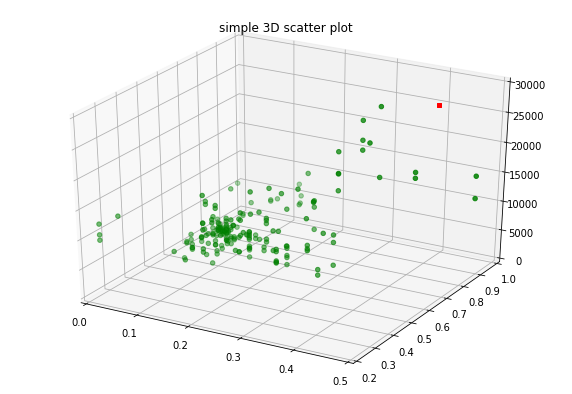

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d

x=numeric_cars['engine-size']
y=numeric_cars['highway-mpg']
z=numeric_cars['price']
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection='3d')
 
# Creating plot
ax.scatter3D(x, y, z, color = "green")
plt.title("simple 3D scatter plot")
ax.scatter3D([.45],[0.8],[29000],color='red',marker='s')
# show plot
plt.xlim(0,0.5)
plt.ylim(0.2,1)
ax.set_zlim(0,30000)
plt.show()

In [203]:
from sklearn.model_selection import cross_val_score, KFold

def knn_train_test(df,feature,target,n=5,folds=10):
    kf=KFold(n_splits=folds,shuffle=True,random_state=1)
    knn=KNeighborsRegressor(n_neighbors=n,algorithm='brute')
    mses=cross_val_score(estimator=knn,X=df[feature],y=df[target],scoring='neg_mean_squared_error',cv=kf)
    avg_rsme=np.mean(np.sqrt(np.absolute(mses)))
    return avg_rsme


In [207]:
rsmes_univariate={}
for col in numeric_cars[features].columns:
    rsme_col=knn_train_test(df=numeric_cars,feature=[col],target='price')
    rsmes_univariate[col]=rsme_col
rsmes_univariate

{'normalized-losses': 6323.013399622463,
 'wheel-base': 5676.480374517227,
 'length': 5049.551484658347,
 'width': 4274.563982170558,
 'height': 7617.330945525906,
 'curb-weight': 4248.131164348986,
 'engine-size': 3022.066973616294,
 'bore': 6787.242702984874,
 'stroke': 7184.461340623811,
 'compression-ratio': 6511.23288304368,
 'horsepower': 3843.6257133375448,
 'peak-rpm': 7227.497100872575,
 'city-mpg': 4212.517293004572,
 'highway-mpg': 4272.058028231421}

In [211]:
min(rsmes_univariate.items(), key=lambda x: x[1]) 

('engine-size', 3022.066973616294)

In [219]:
rsmes_univariate=pd.Series(rsmes_univariate).sort_values()
rsmes_univariate

engine-size          3022.066974
horsepower           3843.625713
city-mpg             4212.517293
curb-weight          4248.131164
highway-mpg          4272.058028
width                4274.563982
length               5049.551485
wheel-base           5676.480375
normalized-losses    6323.013400
compression-ratio    6511.232883
bore                 6787.242703
stroke               7184.461341
peak-rpm             7227.497101
height               7617.330946
dtype: float64

In [214]:
ks=[1,3,5,7,9]
rsmes_univariate_k={}
for col in numeric_cars[features].columns:
    k_neighbors={}
    for k in ks:
        rsme_col=knn_train_test(df=numeric_cars,feature=[col],target='price',n=k)
        k_neighbors[k]=rsme_col
    rsmes_univariate_k[col]=k_neighbors

In [215]:
rsmes_univariate_k

{'normalized-losses': {1: 6773.737662669698,
  3: 6129.283046437764,
  5: 6323.013399622463,
  7: 6878.903952452466,
  9: 7523.823920998674},
 'wheel-base': {1: 4838.811735426543,
  3: 4788.918931896196,
  5: 5676.480374517227,
  7: 5966.842431834928,
  9: 5888.137986356905},
 'length': {1: 5092.264401956441,
  3: 5230.033935409053,
  5: 5049.551484658347,
  7: 5301.361304144377,
  9: 5400.703964848575},
 'width': {1: 4990.5188305466945,
  3: 4217.846360101605,
  5: 4274.563982170558,
  7: 4408.260228765127,
  9: 4370.133823152318},
 'height': {1: 10559.769233683894,
  3: 8122.506562495744,
  5: 7617.330945525906,
  7: 7570.889893561279,
  9: 7435.227162200526},
 'curb-weight': {1: 5131.016591427542,
  3: 4585.946768732755,
  5: 4248.131164348986,
  7: 4115.152341202806,
  9: 3966.241024982434},
 'engine-size': {1: 3851.652772164489,
  3: 3264.0359997322735,
  5: 3022.066973616294,
  7: 3264.995147253416,
  9: 3479.1845889746255},
 'bore': {1: 9361.967611905924,
  3: 9261.250177810802,

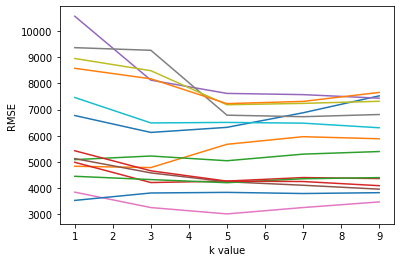

In [216]:
import matplotlib.pyplot as plt
%matplotlib inline

for k,v in rsmes_univariate_k.items():
    x = list(v.keys())
    y = list(v.values())
    
    plt.plot(x,y)
    plt.xlabel('k value')
    plt.ylabel('RMSE')

In [222]:
rsmes_univariate.index

Index(['engine-size', 'horsepower', 'city-mpg', 'curb-weight', 'highway-mpg',
       'width', 'length', 'wheel-base', 'normalized-losses',
       'compression-ratio', 'bore', 'stroke', 'peak-rpm', 'height'],
      dtype='object')

In [223]:
rsmes_multi={}
for i in range(2,6):
    rsme_i=knn_train_test(df=numeric_cars,feature=rsmes_univariate.index[:i],target='price')
    rsmes_multi[i]=rsme_i

In [224]:
rsmes_multi

{2: 2756.624628446917,
 3: 2708.613868515616,
 4: 2960.2105168549483,
 5: 2982.2549470756003}

In [225]:
rsmes_multivariate={}
for i in range(2,6):
    rsme_i_kneighbors={}
    for k in range(1,26):
        rsme_i_k=knn_train_test(df=numeric_cars,feature=rsmes_univariate.index[:i],target='price',n=k)
        rsme_i_kneighbors[k]=rsme_i_k
    rsmes_multivariate[i]=rsme_i_kneighbors
        
        

In [233]:
rsmes_multivariate=pd.DataFrame(rsmes_multivariate)
rsmes_multivariate.columns=['two features','three feature','four feature','five features']

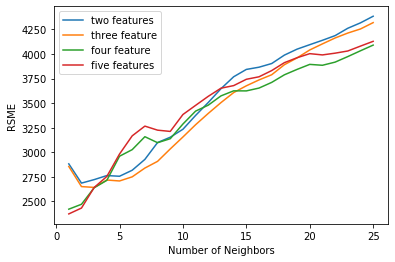

In [234]:
plt.plot(rsmes_multivariate)
plt.xlabel('Number of Neighbors')
plt.ylabel('RSME')
plt.legend(labels=rsmes_multivariate.columns)